# Satellite Imagery for ARI Manual Classification Workflow <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
The ability to extract pixel boundaries as a shapefile or other vector file type is very useful for remote sensing applications where the boundaries of the pixel are needed. 
This is useful for matching drone imagery with remotely sensed imagery. The Fractional Cover of Water project requires us to use satellite imagery from Landsat and Sentinel 2 satellites that match our drone imagery from our field sites. We take the matching imagery, find the pixel edges, and then manually classify what is in the pixels (what type of wet vegetation we have and what fraction of the pixel it covers), in order to create input data for the algorithm. 


## Description
This notebook uses Digital Earth Australia to retrieve satellite data, creates a vector file from the pixel boundaries of the data, and exports to file.

1. First we load some data for a chosen time frame and area using the dea-notebooks `load_ard` function
2. Then we convert our raster data into a polygon per pixel
3. Then we export our pixel edges polygons as a vector file (e.g. ESRI Shapefile or GeoJSON)
4. This loop is repeated (once for Sentinel-2 data and once for Landsat data)

#FIXME: additional steps

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import rasterio.features
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
from datacube.utils.cog import write_cog

sys.path.append("../../../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb


### Define useful functions
The function below is a helper function to help you make a nice filename for the output files

In [2]:
def create_filename(ds, image_index, query, prefix=""):
    """
    Create_filename is a handy function to turn your xarray.Dataset 
    and image number into a nice output filename for your shapefile.
    
    Parameters
    ----------
    ds : xarray.Dataset
        Input xarray.Dataset data
    image_index : int
        An integer value between 0 and however many images you have
    prefix : string, optional 
        An optional name prefix to identify your area of interest
        """
    assert ds
    
    image_date = str(ds.nbart_red[image_index].time.data)[:10]
    image_coords = f"{query['x'][0]}_{query['y'][0]}_{query['x'][1]}_{query['y'][1]}"
    
    if prefix:
        output_name = f"{str(prefix)}_{image_date}_{image_coords}"
    else:
        output_name = f"{image_date}_{image_coords}"
        print(output_name)
        
    return output_name

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Polygonise_pixel_edges")

### Analysis parameters
* `x` : a tuple of longitude/Easting boundaries defining the area of interest in the format (smaller, larger) e.g. `(153.40, 153.50)`
* `y` : a tuple of latitude/Northing boundaries defining the area of interest in the format (smaller, larger) e.g. `(-27.40, -27.50)`
* `time` : a tuple of time values in a pandas datetime format defining the time period of interest in the format (smaller, larger) e.g. `("2018-08-01", "2018-08-20")`
* `products` : A list of product names to load from the datacube e.g. `['ga_ls7e_ard_3', 'ga_ls8c_ard_3']`
* `measurements` : A list of band names to load from the satellite product e.g. `['nbart_red', 'nbart_green']`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Landsat, this is `(-30, 30)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection
* `group_by` : How to group the data e.g. `"solar_day"`

## Sentinel-2 example 
### Set up a datacube query for area of interest
Set up a query to load Sentinel-2 satellite data:

In [4]:
# Create a query object
s2_query = {
    "x": (153.44, 153.45),
    "y": (-27.42, -27.43),
    "time": ("2018-08-01", "2018-08-20"),
    "products": ("s2a_ard_granule", "s2b_ard_granule"),
    "measurements": ["nbart_red", "nbart_green", "nbart_blue", "fmask"],
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

Load available data from Sentinel 2 satellites:

In [5]:
# Load Sentinel-2 data using `load_ard`. We're not using fmask to mask our 
# pixel quality, as we're after the surrounds of the pixels not big white blobs.
s2_ds = load_ard(
    dc=dc,
    min_gooddata=0.95,  # only take scenes with less than 5% fmask activations
    mask_pixel_quality=False,
    **s2_query
)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 8 out of 8 time steps with at least 95.0% good quality pixels
Loading 8 time steps


### Plot up some data to take a look at it
Use the `rgb` function from `dea-plotting` module to look at our area of interest in true colour

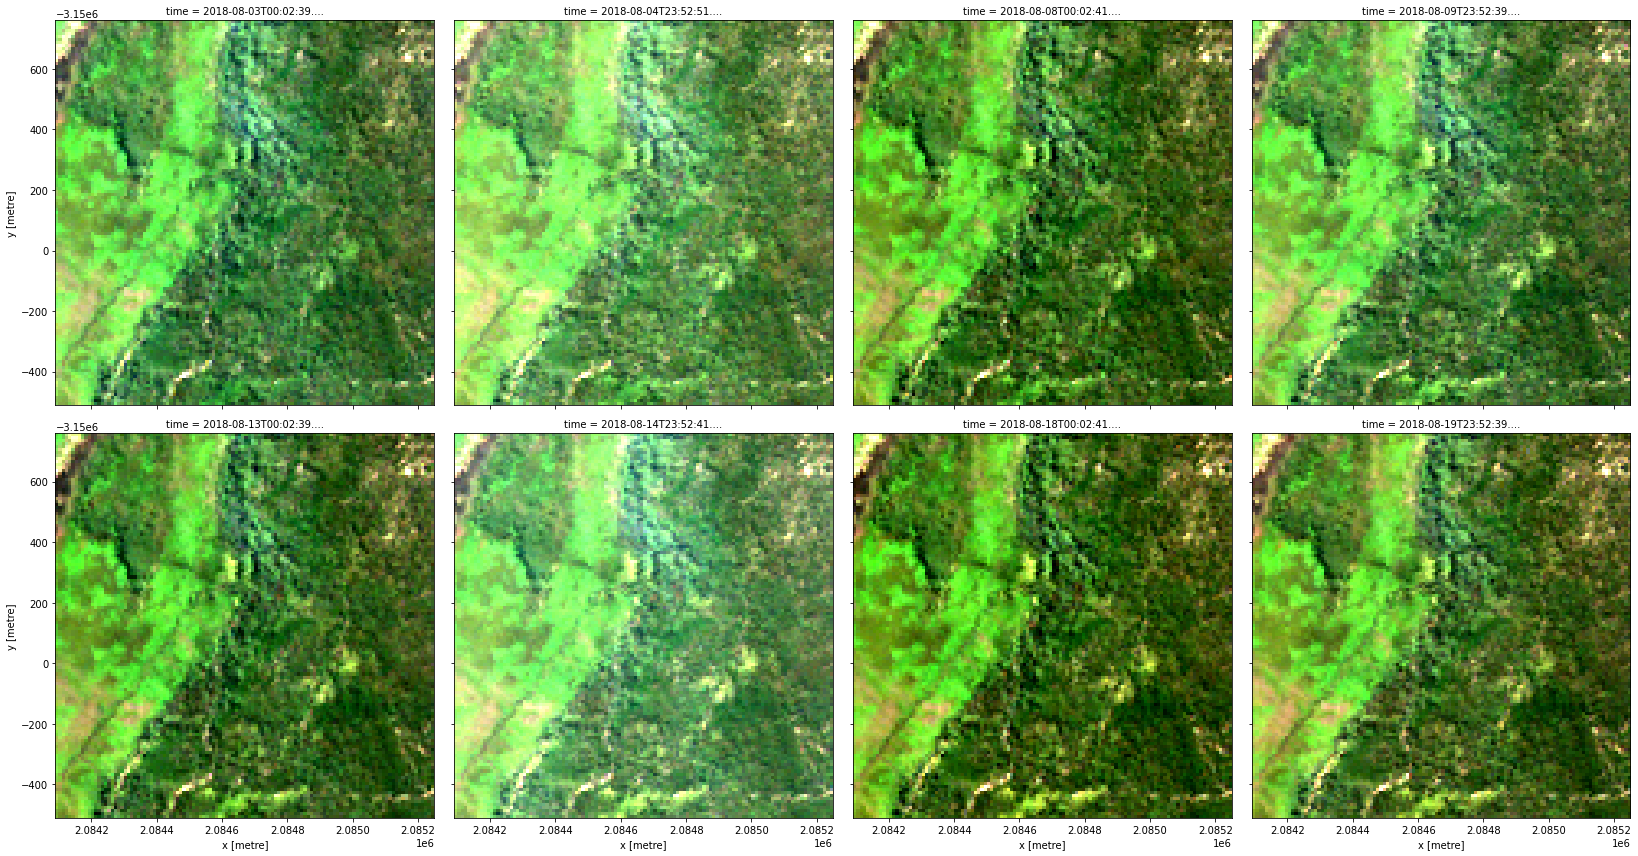

In [6]:
rgb(s2_ds, bands=["nbart_red", "nbart_green", "nbart_blue"], col="time")

### Choose an image index to use to polygonise the pixels
Change the number in the cell below to select a different image from the images in the previous cell; 0 is the first image.

In [7]:
image_index = 6

### Segment our image into per-pixel-polygons
Use the red band to create a polygon for each pixel. 

In [8]:
# Input array to segment and vectorise
input_array = s2_ds.nbart_red[image_index]
input_transform = s2_ds.affine  
input_crs = s2_ds.crs

# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

# Vectorise each unique feature in array
vectors = rasterio.features.shapes(
    source=unique_pixels.astype(np.int16), transform=input_transform
)

# Extract polygons and values from generator
vectors = list(vectors)
values = [value for polygon, value in vectors]
polygons = [shape(polygon) for polygon, value in vectors]

s2_poly_gdf=gpd.GeoDataFrame(data={"id": values}, geometry=polygons, crs=input_crs)

#add in some empty fields for our classification here. 
info_fields = ["Overstory","Emergent","Floating","OpenWater","DryVeg","Bare","ForelUleWaterColour"]
for i in info_fields:
    s2_poly_gdf[i]=np.nan 

### Investigate the results
Print and plot the first 5 entries in the polygon GeoDataFrame:

In [9]:
# Print the first 5 rows in the GeoDataFrame
s2_poly_gdf.head()

,id,geometry,Overstory,Emergent,Floating,OpenWater,DryVeg,Bare,ForelUleWaterColour
0,0.0,"POLYGON ((2084090.000 -3149240.000, 2084090.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,"POLYGON ((2084100.000 -3149240.000, 2084100.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,"POLYGON ((2084110.000 -3149240.000, 2084110.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,"POLYGON ((2084120.000 -3149240.000, 2084120.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,"POLYGON ((2084130.000 -3149240.000, 2084130.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot shapefile over raster

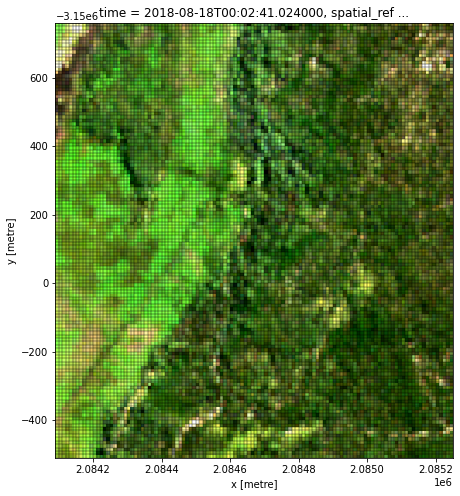

In [10]:
# Plot raster data
fig, ax1 = plt.subplots(figsize=[8, 8])
rgb(
    s2_ds.isel(time=image_index),
    bands=["nbart_red", "nbart_green", "nbart_blue"],
    ax=ax1,
)

# Plot our shapefile over top of our raster
s2_poly_gdf.boundary.plot(color=None, edgecolor="k", linewidth=0.2, ax=ax1)
plt.show()

### Write polygonised pixel edges to file
Change the prefix in the cell below for a customised filename, and write our new segmented shapefile out to a file:

In [11]:
output_filename = create_filename(s2_ds, image_index, s2_query, prefix="NS_s2")
s2_poly_gdf.to_file(f"{output_filename}.shp")

### Write corresponding RGB GeoTIFF image data to file
Write the corresponding GeoTIFF out to a file, for checking purposes:

In [12]:
s2_rgb = s2_ds.isel(time=image_index).to_array()
write_cog(s2_rgb, f"{output_filename}.tif", overwrite=True)

PosixPath('NS_s2_2018-08-18_153.44_-27.42_153.45_-27.43.tif')

## Landsat example 

### Set up a datacube query for area of interest
Set up a query to reproduce our workflow using Landsat satellite data:

In [13]:
# Create a landsat query
ls_query = {
    "x": (153.44, 153.45),
    "y": (-27.42, -27.43),
    "time": ("2018-08-01", "2018-08-20"),
    "products": ["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3"],
    "measurements": [
        "nbart_green",
        "nbart_red",
        "nbart_blue",
    ],  # only get the bands we need for plotting and segmenting
    "output_crs": "EPSG:3577",
    "resolution": (-30, 30),
    "group_by": "solar_day",
}

### Load available data from Landsat satellites

In [14]:
# Load landsat data using `load_ard`
ls_ds = load_ard(dc=dc, ls7_slc_off=False, **ls_query)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 1 time steps


### Plot data
Use the `rgb` function from `dea_plotting` module to look at our area of interest in true colour:

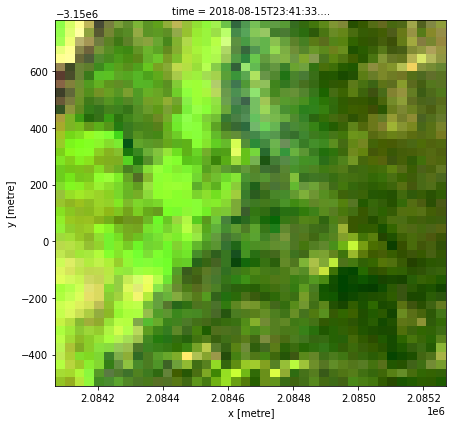

In [15]:
rgb(ls_ds, bands=["nbart_red", "nbart_green", "nbart_blue"], col="time")

In [16]:
image_index = 0

### Segment image into per-pixel-polygons
Use the red band to create a polygon for each pixel. 

In [17]:
# Input array to segment and vectorise
input_array = ls_ds.nbart_red[image_index]
input_transform = ls_ds.affine
input_crs = ls_ds.crs

# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

# Vectorise each unique feature in array
vectors = rasterio.features.shapes(
    source=unique_pixels.astype(np.int16), transform=input_transform
)

# Extract polygons and values from generator
vectors = list(vectors)
values = [value for polygon, value in vectors]
polygons = [shape(polygon) for polygon, value in vectors]

# Create a geopandas dataframe populated with the polygon shapes
ls_poly_gdf = gpd.GeoDataFrame(data={"id": values}, geometry=polygons, crs=input_crs)

#add in some empty fields for our classification here. 
info_fields = ["Overstory","Emergent","Floating","OpenWater","DryVeg","Bare","ForelUleWaterColour"]
for i in info_fields:
    ls_poly_gdf[i]=np.nan 

### Investigate the results
Print and plot the first 5 entries in the polygon GeoDataFrame:

In [18]:
# Print the first 5 rows in the GeoDataFrame
ls_poly_gdf.head()

,id,geometry,Overstory,Emergent,Floating,OpenWater,DryVeg,Bare,ForelUleWaterColour
0,0.0,"POLYGON ((2084070.000 -3149220.000, 2084070.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,"POLYGON ((2084100.000 -3149220.000, 2084100.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,"POLYGON ((2084130.000 -3149220.000, 2084130.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,"POLYGON ((2084160.000 -3149220.000, 2084160.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,"POLYGON ((2084190.000 -3149220.000, 2084190.00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot shapefile over raster

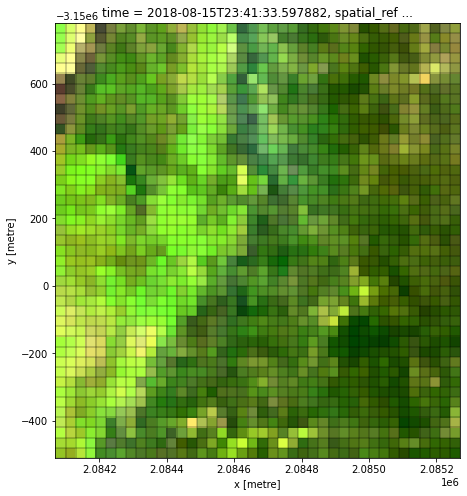

In [19]:
# Plot raster data
fig, ax1 = plt.subplots(figsize=[8,8])
rgb(ls_ds.isel(time=image_index), bands=["nbart_red", "nbart_green", "nbart_blue"], ax=ax1)

# Plot our shapefile over top of our raster
ls_poly_gdf.boundary.plot(color=None, edgecolor='k', linewidth = 0.2, ax=ax1)
plt.show()

### Write polygonised pixel edges out to file
Write our new segmented Landsat pixel edge shapefile out to a file (change the prefix in the cell below for a customised filename):

In [20]:
output_filename = create_filename(ls_ds, image_index, ls_query, prefix="NS_ls")
ls_poly_gdf.to_file(f"{output_filename}.shp")

### Write corresponding RGB GeoTIFF image data to file
Write the corresponding geotiff out to a file, for checking purposes:

In [21]:
ls_rgb = ls_ds.isel(time=image_index).to_array()
write_cog(ls_rgb, f"{output_filename}.tif", overwrite=True)

PosixPath('NS_ls_2018-08-15_153.44_-27.42_153.45_-27.43.tif')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2020

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)